In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
# set the matplotlib backend so figures can be saved in the background
import matplotlib
matplotlib.use("Agg")
# import the necessary packages
#from pyimagesearch.models import ResNet
#from pyimagesearch.az_dataset import load_mnist_dataset
#from pyimagesearch.az_dataset import load_az_dataset
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import SGD
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import build_montages
import matplotlib.pyplot as plt
import numpy as np
import argparse
import cv2

Building OCR Model

In [3]:
from tensorflow.keras.datasets import mnist

def load_mnist_dataset():

  # load data from tensorflow framework
  ((trainData, trainLabels), (testData, testLabels)) = mnist.load_data() 

  # Stacking train data and test data to form single array named data
  data = np.vstack([trainData, testData]) 

  # Vertical stacking labels of train and test set
  labels = np.hstack([trainLabels, testLabels]) 

  # return a 2-tuple of the MNIST data and labels
  return (data, labels)

In [4]:

def load_az_dataset(datasetPath):

  # List for storing data
  data = []
  
  # List for storing labels
  labels = []
  
  for row in open(datasetPath): #Openfile and start reading each row
    #Split the row at every comma
    row = row.split(",")
    
    #row[0] contains label
    label = int(row[0])
    
    #Other all collumns contains pixel values make a saperate array for that
    image = np.array([int(x) for x in row[1:]], dtype="uint8")
    
    #Reshaping image to 28 x 28 pixels
    image = image.reshape((28, 28))
    
    #append image to data
    data.append(image)
    
    #append label to labels
    labels.append(label)
    
  #Converting data to numpy array of type float32
  data = np.array(data, dtype='float32')
  
  #Converting labels to type int
  labels = np.array(labels, dtype="int")
  
  return (data, labels)

In [5]:
(digitsData, digitsLabels) = load_mnist_dataset()

(azData, azLabels) = load_az_dataset('/content/drive/MyDrive/Colab Notebooks/ocr/A_Z Handwritten Data.csv')

11501568/11490434 [==============================] - 0s 0us/step


Combining datasets and dataset preparation

In [6]:

# the MNIST dataset occupies the labels 0-9, so let's add 10 to every A-Z label to ensure the A-Z characters are not incorrectly labeled 

azLabels += 10

# stack the A-Z data and labels with the MNIST digits data and labels

data = np.vstack([azData, digitsData])
labels = np.hstack([azLabels, digitsLabels])

# Each image in the A-Z and MNIST digts datasets are 28x28 pixels;
# However, the architecture we're using is designed for 32x32 images,
# So we need to resize them to 32x32

data = [cv2.resize(image, (32, 32)) for image in data]
data = np.array(data, dtype="float32")

# add a channel dimension to every image in the dataset and scale the
# pixel intensities of the images from [0, 255] down to [0, 1]

data = np.expand_dims(data, axis=-1)
data /= 255.0

In [7]:
from sklearn.preprocessing import LabelBinarizer

le = LabelBinarizer()
labels = le.fit_transform(labels)

counts = labels.sum(axis=0)

# account for skew in the labeled data
classTotals = labels.sum(axis=0)
classWeight = {}

# loop over all classes and calculate the class weight
for i in range(0, len(classTotals)):
  classWeight[i] = classTotals.max() / classTotals[i]

# partition the data into training and testing splits using 80% of
# the data for training and the remaining 20% for testing
(trainX, testX, trainY, testY) = train_test_split(data,
	labels, test_size=0.20, stratify=labels, random_state=42)

Performing Data Augmentation

In [8]:
#from keras.preprocessing.image import ImageDataGenerator
# construct the image generator for data augmentation

aug = ImageDataGenerator(
rotation_range=10,
zoom_range=0.05,
width_shift_range=0.1,
height_shift_range=0.1,
shear_range=0.15,
horizontal_flip=False,
fill_mode="nearest")

Building ResNet Architecture

In [9]:
from tensorflow.keras.layers import (
    BatchNormalization, SeparableConv2D, MaxPooling2D, Activation, Flatten, Dropout, Dense
)
from keras.layers.core import Activation
from keras.layers.core import Dense
from keras.layers import Flatten
from keras.layers import Input
from keras.models import Model
from keras.layers import add
from keras.regularizers import l2
from keras import backend as K
from tensorflow.keras.layers import Conv2D

class ResNet:
	@staticmethod
	def residual_module(data, K, stride, chanDim, red=False,
		reg=0.0001, bnEps=2e-5, bnMom=0.9):
		# the shortcut branch of the ResNet module should be
		# initialize as the input (identity) data
		shortcut = data

		# the first block of the ResNet module are the 1x1 CONVs
		bn1 = BatchNormalization(axis=chanDim, epsilon=bnEps,
			momentum=bnMom)(data)
		act1 = Activation("relu")(bn1)
		conv1 = Conv2D(int(K * 0.25), (1, 1), use_bias=False,
			kernel_regularizer=l2(reg))(act1)

		# the second block of the ResNet module are the 3x3 CONVs
		bn2 = BatchNormalization(axis=chanDim, epsilon=bnEps,
			momentum=bnMom)(conv1)
		act2 = Activation("relu")(bn2)
		conv2 = Conv2D(int(K * 0.25), (3, 3), strides=stride,
			padding="same", use_bias=False,
			kernel_regularizer=l2(reg))(act2)

		# the third block of the ResNet module is another set of 1x1
		# CONVs
		bn3 = BatchNormalization(axis=chanDim, epsilon=bnEps,
			momentum=bnMom)(conv2)
		act3 = Activation("relu")(bn3)
		conv3 = Conv2D(K, (1, 1), use_bias=False,
			kernel_regularizer=l2(reg))(act3)

		# if we are to reduce the spatial size, apply a CONV layer to
		# the shortcut
		if red:
			shortcut = Conv2D(K, (1, 1), strides=stride,
				use_bias=False, kernel_regularizer=l2(reg))(act1)

		# add together the shortcut and the final CONV
		x = add([conv3, shortcut])

		# return the addition as the output of the ResNet module
		return x

	@staticmethod
	def build(width, height, depth, classes, stages, filters,
		reg=0.0001, bnEps=2e-5, bnMom=0.9, dataset="cifar"):
		# initialize the input shape to be "channels last" and the
		# channels dimension itself
		inputShape = (height, width, depth)
		chanDim = -1

		# if we are using "channels first", update the input shape
		# and channels dimension
		if K.image_data_format() == "channels_first":
			inputShape = (depth, height, width)
			chanDim = 1

		# set the input and apply BN
		inputs = Input(shape=inputShape)
		x = BatchNormalization(axis=chanDim, epsilon=bnEps,
			momentum=bnMom)(inputs)

		# check if we are utilizing the CIFAR dataset
		if dataset == "cifar":
			# apply a single CONV layer
			x = Conv2D(filters[0], (3, 3), use_bias=False,
				padding="same", kernel_regularizer=l2(reg))(x)

		# check to see if we are using the Tiny ImageNet dataset
		elif dataset == "tiny_imagenet":
			# apply CONV => BN => ACT => POOL to reduce spatial size
			x = Conv2D(filters[0], (5, 5), use_bias=False,
				padding="same", kernel_regularizer=l2(reg))(x)
			x = BatchNormalization(axis=chanDim, epsilon=bnEps,
				momentum=bnMom)(x)
			x = Activation("relu")(x)
			x = ZeroPadding2D((1, 1))(x)
			x = MaxPooling2D((3, 3), strides=(2, 2))(x)

		# loop over the number of stages
		for i in range(0, len(stages)):
			# initialize the stride, then apply a residual module
			# used to reduce the spatial size of the input volume
			stride = (1, 1) if i == 0 else (2, 2)
			x = ResNet.residual_module(x, filters[i + 1], stride,
				chanDim, red=True, bnEps=bnEps, bnMom=bnMom)

			# loop over the number of layers in the stage
			for j in range(0, stages[i] - 1):
				# apply a ResNet module
				x = ResNet.residual_module(x, filters[i + 1],
					(1, 1), chanDim, bnEps=bnEps, bnMom=bnMom)

		# apply BN => ACT => POOL
		x = BatchNormalization(axis=chanDim, epsilon=bnEps,
			momentum=bnMom)(x)
		x = Activation("relu")(x)
		x = AveragePooling2D((8, 8))(x)

		# softmax classifier
		x = Flatten()(x)
		x = Dense(classes, kernel_regularizer=l2(reg))(x)
		x = Activation("softmax")(x)

		# create the model
		model = Model(inputs, x, name="resnet")

		# return the constructed network architecture
		return model

Compiling model

In [11]:
#from tensorflow.keras.optimizers import SGD
from tensorflow.keras.layers import AveragePooling2D

EPOCHS = 2
INIT_LR = 1e-1
BS = 128

opt = SGD(learning_rate=INIT_LR, decay=INIT_LR / EPOCHS)

model = ResNet.build(32, 32, 1, len(le.classes_), (3, 3, 3),
(64, 64, 128, 256), reg=0.0005)

model.compile(loss="categorical_crossentropy", optimizer=opt,metrics=["accuracy"])

H = model.fit(
aug.flow(trainX, trainY, batch_size=BS),
validation_data=(testX, testY),
steps_per_epoch=len(trainX) // BS,epochs=EPOCHS,
class_weight=classWeight,
verbose=1)

Epoch 1/2
2765/2765 [==============================] - 6974s 3s/step - loss: 5.5332 - accuracy: 0.7313 - val_loss: 0.9404 - val_accuracy: 0.8498
Epoch 2/2
2765/2765 [==============================] - 7011s 3s/step - loss: 2.9612 - accuracy: 0.8461 - val_loss: 0.7862 - val_accuracy: 0.8644


Model Evaluation

In [12]:
labelNames = "0123456789"

labelNames += "ABCDEFGHIJKLMNOPQRSTUVWXYZ"

labelNames = [l for l in labelNames]

predictions = model.predict(testX, batch_size=BS)

print(classification_report(testY.argmax(axis=1), predictions.argmax(axis=1), target_names=labelNames))

              precision    recall  f1-score   support

           0       0.20      0.65      0.30      1381
           1       0.95      0.96      0.95      1575
           2       0.75      0.80      0.77      1398
           3       0.84      0.96      0.90      1428
           4       0.80      0.88      0.84      1365
           5       0.38      0.84      0.52      1263
           6       0.86      0.91      0.88      1375
           7       0.90      0.95      0.92      1459
           8       0.75      0.90      0.81      1365
           9       0.85      0.95      0.90      1392
           A       0.93      0.95      0.94      2774
           B       0.91      0.92      0.91      1734
           C       0.98      0.93      0.95      4682
           D       0.83      0.87      0.85      2027
           E       0.97      0.94      0.95      2288
           F       0.93      0.99      0.96       232
           G       0.86      0.88      0.87      1152
           H       0.87    

Save Model

In [14]:
model.save('OCR_Resnet.h5',save_format=".h5")

Random Testing

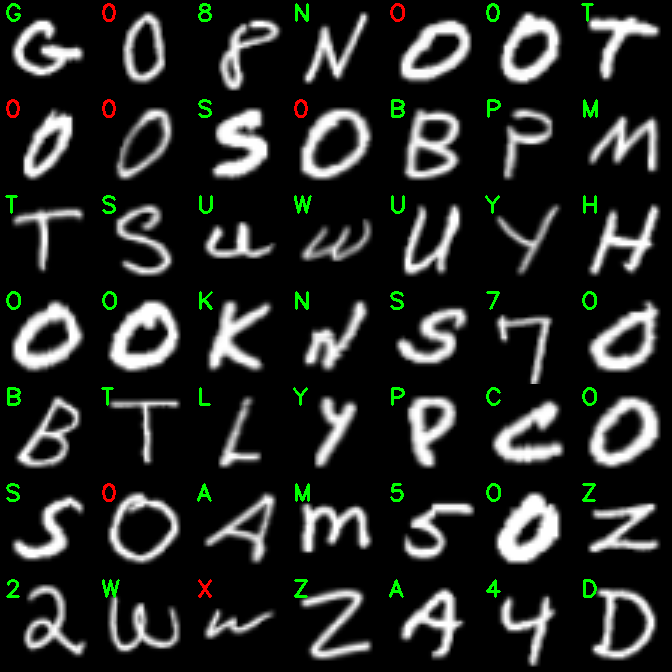

-1

In [21]:

# initialize our list of output test images
images = []
# randomly select a few testing characters
for i in np.random.choice(np.arange(0, len(testY)), size=(49,)):
	# classify the character
	probs = model.predict(testX[np.newaxis, i])
	prediction = probs.argmax(axis=1)
	label = labelNames[prediction[0]]
	# extract the image from the test data and initialize the text
	# label color as green (correct)
	image = (testX[i] * 255).astype("uint8")
	color = (0, 255, 0)
	# otherwise, the class label prediction is incorrect
	if prediction[0] != np.argmax(testY[i]):
		color = (0, 0, 255)
	# merge the channels into one image, resize the image from 32x32
	# to 96x96 so we can better see it and then draw the predicted
	# label on the image
	image = cv2.merge([image] * 3)
	image = cv2.resize(image, (96, 96), interpolation=cv2.INTER_LINEAR)
	cv2.putText(image, label, (5, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.75,
		color, 2)
	# add the image to our list of output images
	images.append(image)
# construct the montage for the images
montage = build_montages(images, (96, 96), (7, 7))[0]
# show the output montage
cv2_imshow(montage)
cv2.waitKey(0)



Testing with choosen picture

In [41]:

from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing import image  

img_path = '/content/1.jpeg'
im = image.load_img(img_path)
#i = image.img_to_array(i)/255.0
#i = i.reshape(1, 224,224,3)

# initialize our list of output test images
images = []
# randomly select a few testing characters
for i in np.random.choice(np.arange(0, len(testY)), size=(49,)):
	# classify the character
	probs = model.predict(testX[np.newaxis, i])
	prediction = probs.argmax(axis=1)
	label = labelNames[prediction[0]]
	# extract the image from the test data and initialize the text
	# label color as green (correct)
	image = (testX[i] * 255).astype("uint8")
	color = (0, 255, 0)
	# otherwise, the class label prediction is incorrect
	if prediction[0] != np.argmax(testY[i]):
		color = (0, 0, 255)
	# merge the channels into one image, resize the image from 32x32
	# to 96x96 so we can better see it and then draw the predicted
	# label on the image
	image = cv2.merge([im] * 3)
	image = cv2.resize(im, (96, 96), interpolation=cv2.INTER_LINEAR)
	cv2.putText(im, label, (5, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.75,
		color, 2)
	# add the image to our list of output images
	images.append(im)
# construct the montage for the images
montage = build_montages(images, (96, 96), (7, 7))[0]
# show the output montage
cv2_imshow(montage)
cv2.waitKey(0)



TypeError: ignored

In [22]:
from google.colab import files

img = files.upload()

Saving 1.jpeg to 1.jpeg


In [27]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing import image  

model = load_model('/content/OCR_Resnet.h5')
#model = load_model('/content/drive/MyDrive/Colab Notebooks/restes/Hasil Training/best_model.h5')
#classes = ['A full', 'A half', 'A seper16', 'A seper4', 'A seper8', 'B full', 'B half', 'B seper16', 'B seper4', 'B seper8', 'C full', 'C half', 'C seper16', 'C seper4', 'C seper8', "C' full", "C' half", "C' seper16", "C' seper4", "C' seper8", 'D full', 'D half', 'D seper16', 'D seper4', 'D seper8', 'E full', 'E half', 'E seper16', 'E seper4', 'E seper8', 'F full', 'F half', 'F seper16', 'F seper4', 'F seper8', 'G full', 'G half', 'G seper16', 'G seper4', 'G seper8']


model.make_predict_function()


def predict_label(img_path):


  i = image.load_img(img_path, target_size=(224,224))
  i = image.img_to_array(i)/255.0
  i = i.reshape(1, 224,224,3)
  #p = model.predict_classes(i)

  p = model.predict(i)
  p = np.argmax(p, axis=1)
  result = {'hasil': ''}
  result['hasil']= classes[p[0]]
  

  return result
path1 = '/content/1.jpeg'
path2 = '/content/gambar kucing.jpg'
print('file direktori : '+path1)
result = predict_label(path1)

print('hasil deteksi :')
print(result)


file direktori : /content/1.jpeg


ValueError: ignored